In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../dataset/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] # crop the first latter and append the one ahead
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [5]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [6]:
g = torch.Generator().manual_seed(2147483647) # To generate same random numbers everytime

C = torch.randn((27, 10), generator=g)

W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

11897

In [7]:
lri = []
lossi = []
stepi = []

In [ ]:
# Iterations...
for i in range(200000):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (100,))

    # Forward Pass
    emb = C[Xtr[ix]] # shape = (32, 3, 10)
    hidden_layer = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1) # shape = (32, 200)
    logits = hidden_layer @ W2 + b2 # shape = (32, 27)

    loss = F.cross_entropy(logits, Ytr[ix])
    print("Loss: ", loss.item())

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # Update
    lr = 0.01 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

600000

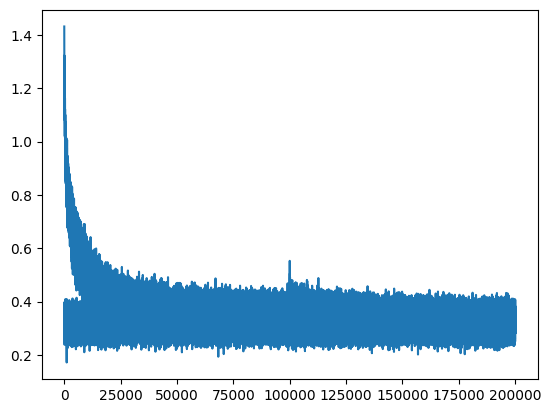

In [20]:
plt.plot(stepi, lossi)
len(lossi)

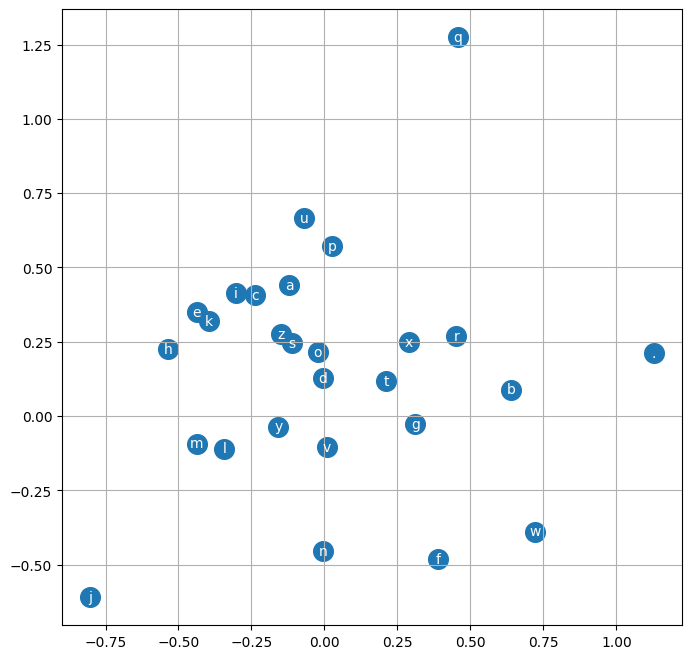

In [24]:
# Visualizing our 2d embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [21]:
# Evaluating dev loss
emb = C[Xdev] # shape = (len(Xdev[0]), 3, 2)
hidden_layer = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1235, grad_fn=<NllLossBackward0>)

In [22]:
# Evaluating dev loss
emb = C[Xtest] # shape = (len(Xtest[0]), 3, 2)
hidden_layer = torch.tanh(emb.view(emb.shape[0], 30) @ W1 + b1) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1193, grad_fn=<NllLossBackward0>)

In [23]:
# Sampling words

result = []
block_size = 3

for _ in range(20):
    block = [0] * block_size
    pred_word = []
    while True:
        Xt = torch.tensor([block])

        # Forward Pass
        embed = C[Xt] # shape = (1, 3, 2)
        hidden_layer = torch.tanh(embed.view(embed.shape[0], 30) @ W1 + b1) # shape = (32, 100)
        logits = hidden_layer @ W2 + b2 # shape = (32, 27)

        counts = torch.exp(logits)
        prob = counts / counts.sum(1, keepdims=True)

        pred_target = torch.multinomial(prob, num_samples=1, replacement=True, generator=g)
        pred_character = itos[pred_target.item()]
        # print(pred_character)

        if pred_character == '.':
            break

        pred_word.append(pred_character)
        block = block[1:] + [pred_target.item()]

    result.append(''.join(pred_word))

result

['hoda',
 'shrist',
 'jadeen',
 'kale',
 'emmeren',
 'jir',
 'zitia',
 'azire',
 'sha',
 'syr',
 'lyo',
 'criyah',
 'myah',
 'jafer',
 'layna',
 'demileilani',
 'lylenn',
 'blakia',
 'amari',
 'fucteejahni']